# Survival Analysis in Python


Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

## Introduction

This notebook introduces Kaplan-Meier estimation, a way to estimate a hazard function when the dataset includes both complete and incomplete cases.

### Setup

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install lifelines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf, Cdf, Surv, Hazard

In [3]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

## Hypothetical data

To demonstrate the basics of survival analysis, I'll use a small set of hypothetical data.  Suppose you are investigating the time it takes for dogs to get adopted from a shelter.  You visit a shelter every week for 10 weeks, and record the arrival time for each dog and the adoption time for each dog that was adopted.

Here's what the data might look like.  It contains one row for each dog and three columns:

* `start`: arrival time, in weeks since the beginning of the study

* `end`: adoption date, for dogs that were adopted, or `9` for dogs that had not been adopted at the end of the study

* `status`: `1` for dogs that were adopted; `0` for dogs that were not.

In [4]:
obs = pd.DataFrame()

obs['start'] = 0,1,2,2,4,6,7
obs['end'] = 5,2,6,9,9,8,9
obs['status'] = 1,1,1,0,0,1,0

obs

,start,end,status
0,0,5,1
1,1,2,1
2,2,6,1
3,2,9,0
4,4,9,0
5,6,8,1
6,7,9,0


## Plotting lifelines

The following function visualizes the data so we can get a better sense of what it looks like.

In [5]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    decorate(xlabel='Time (weeks)',
             ylabel='Dog index')

    plt.gca().invert_yaxis()

Here are the results:

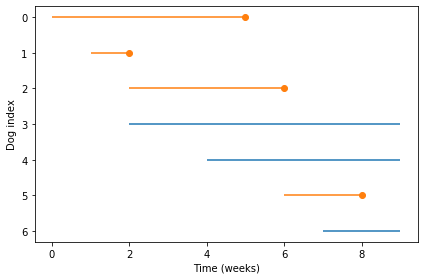

In [6]:
plot_lifelines(obs)

We can see, for example:

* The dog with index 0 arrived during week 0, and was adopted during week 5.

* The dog with index 3 arrived during week 2, and had not been adopted at the end of week 9.


## Estimating survival

Now suppose we want to know the distribution of "survival time" from arrival to adoption.

For the dogs that were adopted, we have all the data we need.  

For the others, we have only partial information: if a dog hasn't been adopted yet, we don't know when it will be, but we can put a lower bound on it.

It might be tempting to ignore the dogs that haven't been adopted and use only the observations that are "complete".  

That will turn out to be a bad idea, but I'll do it anyway because it will lead us to a better idea.

First, I'll compute durations for each dog:

In [7]:
duration = obs['end'] - obs['start']
duration

0    5
1    1
2    4
3    7
4    5
5    2
6    2
dtype: int64

Now I'll extract the durations for the dogs that were adopted, with `status==1`:

In [8]:
complete = duration[obs['status']==1]
complete

0    5
1    1
2    4
5    2
dtype: int64

With this data, we can use `value_counts` to compute an unnormalized PMF:

In [9]:
pmf = pd.value_counts(complete).sort_index()
pmf

1    1
2    1
4    1
5    1
dtype: int64

Next we can compute the cumulative sum of the PMF, which is the CDF.

In [10]:
cdf = pmf.cumsum()
cdf

1    1
2    2
4    3
5    4
dtype: int64

This means that 1 dog was adopted in 1 week or less; two dogs were adopted in 2 weeks or less, and so on.

The survival function is the complement of the CDF, so we subtract from the total number of observations:

In [11]:
surv = 4 - cdf
surv

1    3
2    2
4    1
5    0
dtype: int64

This means that 3 dogs took more than 1 week to be adopted, 2 dogs took more than 2 weeks, and so on.

Now, to compute the hazard rate, we compute the ratio of

1) The number of dogs adopted at each time value, which is the PMF.

2) The number of dogs that were available at each time value, which is the sum of the PMF and the survival function.

So we compute the hazard function like this:

In [12]:
haz = pmf / (pmf + surv)
haz

1    0.250000
2    0.333333
4    0.500000
5    1.000000
dtype: float64

The hazard function indicates that 

1) Of the dogs available at 1 week, `1/4` were adopted.

2) Of the dogs available at 2 weeks, `1/3` were adopted.

3) Of the dogs available at 4 weeks, `1/2` were adopted.

3) Of the dogs available at 5 weeks, all were adopted.

In summary, when we have an unbiased sample of complete durations, we can compute the hazard function by computing the PMF, CDF, and survival function.

However, in this example, we don't have an unbiased sample of adoption times, because we ignored the dogs that were not adopted during the observation period.  In the next section, we'll see how to solve this problem.

## Kaplan-Meier estimation

When we have a mixture of complete and incomplete observations -- adopted and unadopted dogs -- we can't compute the PMF directly, as in the previous example.

Instead, we have to work backwards: we estimate the hazard function first, then use it to compute the survival function, CDF, and PMF.

Specifically, we'll use Kaplan-Meier estimation, which is based on two key ideas.

The first idea is that we can ignore the arrival time in the observed data, and consider only the durations.  In effect, we can take the actual lifelines, which look like this:

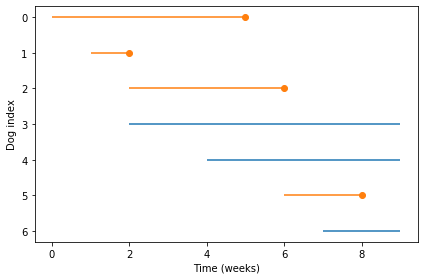

In [13]:
plot_lifelines(obs)

And shift them so they all start at 0, like this:

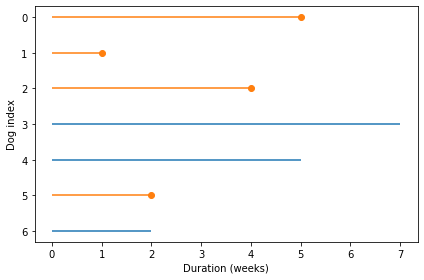

In [14]:
shifted = pd.DataFrame(index=obs.index)
shifted['start'] = 0
shifted['end'] = duration
shifted['status'] = obs['status']

plot_lifelines(shifted)

plt.xlabel('Duration (weeks)');

Notice that the x-axis in this figure is duration, not time.

From this figure, you can pretty much read off the hazard function:

* At duration 1, there is 1 adoption out of 7 dogs at risk, so the hazard rate is `1/7`.

* At duration 2, there is 1 adoption out of 6 dogs at risk, so the hazard rate is `1/6`.

* At duration 4, there is 1 adoption out of 4 dogs at risk, so the hazard rate is `1/4`.

And so on.

Which brings us to the second key idea, which is that we can estimate the hazard rate by computing the ratio of

1) The number of cases that ended at each duration, and

2) The number of cases that *could have* ended at each duration, that is, the number that were "at risk".

The numerator at each duration, `d`, is the PMF of complete cases.

The denominator at `d` is the sum of

1) The number of adopted dogs whose duration was greater than or equal to `d`, and

2) The number of unadopted dogs whose duration was greater than or equal to `d`.

Recall that the survival function is the number of cases that *exceed* `d`, and the PMF if the number of cases with duration *equal to* `d`.

So, to get the number that are *greater than or equal*, we can add the PMF and the survival function.

That's the big picture; now let's see how it's done.

## Estimating the hazard function

First I'll select the durations of the complete and ongoing cases.

In [15]:
complete = duration[obs['status']==1]
complete

0    5
1    1
2    4
5    2
dtype: int64

In [16]:
ongoing = duration[obs['status']==0]
ongoing

3    7
4    5
6    2
dtype: int64

Now I'll compute the PMF for complete and ongoing cases, using unnormalized `Pmf` objects from `empiricaldist`: 

In [17]:
pmf_complete = Pmf.from_seq(complete, normalize=False)
pmf_complete

,probs
1,1
2,1
4,1
5,1


In [18]:
pmf_ongoing = Pmf.from_seq(ongoing, normalize=False)
pmf_ongoing

,probs
2,1
5,1
7,1


When we add two `Pmf` objects, the index of the result is the union of the two indices.

In [19]:
observed = pmf_complete + pmf_ongoing
ts = observed.qs
ts

array([1, 2, 4, 5, 7])

Here's what the PMFs look like in a table.

In [20]:
df = pd.DataFrame(index=ts)
df['pmf_complete'] = pmf_complete
df['pmf_ongoing'] = pmf_ongoing
df

,pmf_complete,pmf_ongoing
1,1.0,NaN
2,1.0,1.0
4,1.0,NaN
5,1.0,1.0
7,NaN,1.0


This table indicates that one dog was adopted at 1 week, another dog was adopted at 2 weeks, and a third dog was observed, unadopted, having been in the shelter for 2 weeks.

We can use the PMFs to compute survival functions for the two groups:

In [21]:
surv_complete = pmf_complete.make_surv()
surv_ongoing = pmf_ongoing.make_surv()

Then we evaluate the survival functions at the times when we observed the cases.

In [22]:
s_complete = surv_complete(ts)
s_ongoing = surv_ongoing(ts)

Here's what that looks like in the table.

In [23]:
df['s_complete'] = s_complete
df['s_ongoing'] = s_ongoing
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing
1,1.0,NaN,3.0,3.0
2,1.0,1.0,2.0,2.0
4,1.0,NaN,1.0,2.0
5,1.0,1.0,0.0,1.0
7,NaN,1.0,0.0,0.0


The first row of this table indicates that 3 of the adopted dogs and 3 of the unadopted dogs were in the shelter for more than 1 week.

We can use this table to compute the number of dogs available at each duration, `d`, which is the sum of:

1) The number cases that end at, `d`, which is `pmf_complete`.

2) The number of ongoing cases observed at `d`, which is `pmf_ongoing`,

3) The number of complete cases that survive past `d`, which is `s_complete`.

4) The number of ongoing cases that survive past `d`, which is `s_complete`.

Here's what that looks like.

In [24]:
at_risk = pmf_complete + pmf_ongoing + s_complete + s_ongoing
df['at_risk'] = at_risk
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk
1,1.0,NaN,3.0,3.0,7.0
2,1.0,1.0,2.0,2.0,6.0
4,1.0,NaN,1.0,2.0,4.0
5,1.0,1.0,0.0,1.0,3.0
7,NaN,1.0,0.0,0.0,1.0




Finally, the hazard function is the ratio of `pmf_complete` and `at_risk`:

In [25]:
hazard = pmf_complete / at_risk

df['hazard'] = hazard
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard
1,1.0,NaN,3.0,3.0,7.0,0.142857
2,1.0,1.0,2.0,2.0,6.0,0.166667
4,1.0,NaN,1.0,2.0,4.0,0.250000
5,1.0,1.0,0.0,1.0,3.0,0.333333
7,NaN,1.0,0.0,0.0,1.0,0.000000


## Working backwards

With the hazard function, we can work backwards to compute the survival curve:

In [26]:
surv = (1 - hazard).cumprod()
df['surv'] = surv
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard,surv
1,1.0,NaN,3.0,3.0,7.0,0.142857,0.857143
2,1.0,1.0,2.0,2.0,6.0,0.166667,0.714286
4,1.0,NaN,1.0,2.0,4.0,0.250000,0.535714
5,1.0,1.0,0.0,1.0,3.0,0.333333,0.357143
7,NaN,1.0,0.0,0.0,1.0,0.000000,0.357143


And the CDF:

In [27]:
cdf = 1 - surv
df['cdf'] = cdf
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard,surv,cdf
1,1.0,NaN,3.0,3.0,7.0,0.142857,0.857143,0.142857
2,1.0,1.0,2.0,2.0,6.0,0.166667,0.714286,0.285714
4,1.0,NaN,1.0,2.0,4.0,0.250000,0.535714,0.464286
5,1.0,1.0,0.0,1.0,3.0,0.333333,0.357143,0.642857
7,NaN,1.0,0.0,0.0,1.0,0.000000,0.357143,0.642857


And the PMF:

In [28]:
pmf = cdf.diff()
pmf[1] = cdf[1]

df['pmf'] = pmf
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard,surv,cdf,pmf
1,1.0,NaN,3.0,3.0,7.0,0.142857,0.857143,0.142857,0.142857
2,1.0,1.0,2.0,2.0,6.0,0.166667,0.714286,0.285714,0.142857
4,1.0,NaN,1.0,2.0,4.0,0.250000,0.535714,0.464286,0.178571
5,1.0,1.0,0.0,1.0,3.0,0.333333,0.357143,0.642857,0.178571
7,NaN,1.0,0.0,0.0,1.0,0.000000,0.357143,0.642857,0.000000


## lifelines

I implemented Kaplan-Meier estimation to show how it works, but I didn't have to; it's available in a library called `lifelines`.

First I'll import it and create a `KaplanMeierFitter`.

In [29]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [30]:
T = duration
T

0    5
1    1
2    4
3    7
4    5
5    2
6    2
dtype: int64

In [31]:
E = obs['status']

In [32]:
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

In [33]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.857143
2.0,0.714286
4.0,0.535714
5.0,0.357143
7.0,0.357143


In [34]:
max(abs(kmf.survival_function_['KM_estimate'] - df['surv']).dropna())

1.6653345369377348e-16